Sure! Here's the English translation:

# Embeddings-based Fake News Classifier

## Overview
This notebook builds a fake news classifier using sentence embeddings (Sentence-Transformers) and a simple linear classifier. Its structure is similar to `enhanced_classifier.ipynb`, but without complex text preprocessing.

Pipeline:
- Installation and import of libraries  
- Data loading  
- Input text formation (title + text)  
- Embedding generation (all-MiniLM-L6-v2)  
- Train/test split  
- Logistic Regression training  
- Quality evaluation  
- Prediction generation for validation and saving to CSV  

If you'd like, I can help you expand this into a full project description or even turn it into a presentation.

In [1]:
# Setup and imports
import sys
!{sys.executable} -m pip install -q sentence-transformers

import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

print('Environment ready')


/Users/sergej/.pyenv/versions/3.11.8/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Environment ready


In [2]:
# Load data
train_df = pd.read_csv('dataset/data.csv')
val_df = pd.read_csv('dataset/validation_data.csv')
print(train_df.shape, val_df.shape)
train_df.head(2)


(39942, 5) (4956, 5)


,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"


In [3]:
# Build input texts (title + text)
train_texts = (train_df['title'].fillna('') + ' ' + train_df['text'].fillna('')).tolist()
val_texts = (val_df['title'].fillna('') + ' ' + val_df['text'].fillna('')).tolist()
y = train_df['label'].values

print('Samples:', len(train_texts), 'Labels:', y.shape)
print(train_texts[0][:200])


Samples: 39942 Labels: (39942,)
As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of


In [4]:
# Encode embeddings
embedder = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

# Train/test split indices
idx = np.arange(len(train_texts))
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42, stratify=y)

X_train = embedder.encode([train_texts[i] for i in train_idx], batch_size=256, convert_to_numpy=True, show_progress_bar=True)
X_test = embedder.encode([train_texts[i] for i in test_idx], batch_size=256, convert_to_numpy=True, show_progress_bar=True)
y_train = y[train_idx]
y_test = y[test_idx]

X_val = embedder.encode(val_texts, batch_size=256, convert_to_numpy=True, show_progress_bar=True)

X_train.shape, X_test.shape, X_val.shape


Batches: 100%|██████████| 20/20 [00:55<00:00,  2.75s/it]


((31953, 384), (7989, 384), (4956, 384))

In [5]:
# Train classifier
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Fake','Real']))


Accuracy: 0.9480535736637877
              precision    recall  f1-score   support

        Fake       0.95      0.94      0.95      3989
        Real       0.94      0.96      0.95      4000

    accuracy                           0.95      7989
   macro avg       0.95      0.95      0.95      7989
weighted avg       0.95      0.95      0.95      7989



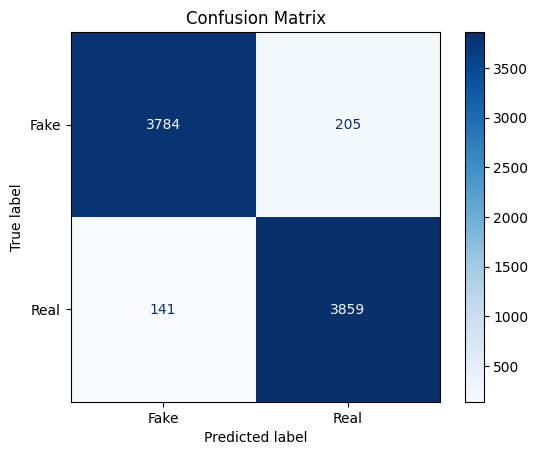

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, classification_report
import matplotlib.pyplot as plt

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'Real'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


In [7]:
# Compare models on embeddings
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
svm = SVC(kernel='linear', probability=True, random_state=42)

models = {
    'LogReg': clf,  # already fitted above
    'RandomForest': rf,
    'LinearSVM': svm
}

results = {}
preds = {}
probas = {}

for name, m in models.items():
    if name != 'LogReg':
        m.fit(X_train, y_train)
    y_pred = m.predict(X_test)
    results[name] = accuracy_score(y_test, y_pred)
    preds[name] = y_pred
    if hasattr(m, 'predict_proba'):
        probas[name] = m.predict_proba(X_test)
    else:
        # SVC without probas (if probability=False), but here True
        probas[name] = None
    print(f"{name} accuracy: {results[name]:.4f}")

best_name = max(results, key=results.get)
best_model = models[best_name]
print(f"\nBest embeddings model: {best_name} ({results[best_name]:.4f})")


LogReg accuracy: 0.9481
RandomForest accuracy: 0.9270
LinearSVM accuracy: 0.9567

Best embeddings model: LinearSVM (0.9567)


In [8]:
# Predict on validation using best model and save
val_pred_best = best_model.predict(X_val)
val_proba_best = best_model.predict_proba(X_val) if hasattr(best_model, 'predict_proba') else None

submission_best = pd.DataFrame({
    'id': range(len(val_df)),
    'label': val_pred_best
})

if val_proba_best is not None:
    submission_best['probability_fake'] = val_proba_best[:, 0]
    submission_best['probability_real'] = val_proba_best[:, 1]

out_path = f'embeddings_fake_news_predictions_{best_name.lower()}.csv'
submission_best.to_csv(out_path, index=False)
print(f'Saved to {out_path}')
submission_best.head()


Saved to embeddings_fake_news_predictions_linearsvm.csv


,id,label,probability_fake,probability_real
0,0,1,5.634485e-07,0.999999
1,1,1,6.812508e-03,0.993187
2,2,1,1.413487e-05,0.999986
3,3,1,8.410532e-03,0.991589
4,4,1,8.643167e-06,0.999991


In [9]:
# Predict on validation and save
val_pred = clf.predict(X_val)
val_proba = clf.predict_proba(X_val)

submission = pd.DataFrame({
    'id': range(len(val_df)),
    'label': val_pred,
    'probability_fake': val_proba[:, 0],
    'probability_real': val_proba[:, 1]
})

submission.to_csv('embeddings_fake_news_predictions.csv', index=False)
print('Saved to embeddings_fake_news_predictions.csv')
submission.head()


Saved to embeddings_fake_news_predictions.csv


,id,label,probability_fake,probability_real
0,0,1,0.010044,0.989956
1,1,1,0.035159,0.964841
2,2,1,0.014708,0.985292
3,3,1,0.032449,0.967551
4,4,1,0.009178,0.990822


In [10]:
# Save validation with predicted labels into dataset
import os

# Try to use in-memory validation data if present; otherwise read from disk
try:
    original_val = validation_data.copy()
except NameError:
    original_val = pd.read_csv('dataset/validation_data.csv')

# Ensure lengths match
assert len(original_val) == len(submission), 'Length mismatch between validation and predictions'

labeled_val = original_val.copy()
labeled_val['label'] = submission['label'].values

out_path = os.path.join('dataset', 'validation_data_labeled_embeddings.csv')
labeled_val.to_csv(out_path, index=False)
print(f"Saved labeled validation to: {out_path}")


Saved labeled validation to: dataset/validation_data_labeled_embeddings.csv
